In [1]:
import utils
import torch
from models.basic_model import CDEvaluator
import os
import numpy as np
import pandas as pd
from typing import TypedDict
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(threads_per_worker=4)
client = Client(cluster)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


2022-06-07 23:42:23,308 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [2]:
args = utils.get_args()
utils.get_device(args)

In [5]:
def load_model():
    args.checkpoint_dir = os.path.join(args.checkpoint_root, args.project_name)
    model = CDEvaluator(args)
    model.load_checkpoint(args.checkpoint_name) 
    model.eval()
    return model
remote_model = client.submit(load_model)
print(remote_model)

<Future: pending, key: load_model-9095fda58a085e44367ba186942287b1>


# Load Planet Data

In [6]:
a = rio.vrt.WarpedVRT(rio.open('./catalogs/17_05/mosaic.tif'))
b = rio.vrt.WarpedVRT(rio.open('./catalogs/22_05/mosaic.tif'),transform=a.transform,height=a.height,width=a.width)

ds1 = rxr.open_rasterio(a,chunks=(4,8192,8192),lock=False)
ds2 = rxr.open_rasterio(b,chunks=(4,8192,8192),lock=False)

ds1 = ds1[:3]
ds2 = ds2[:3]

ds1 = ds1/255.0
ds2 = ds2/255.0

m1 = ds1.mean(axis=[1,2])
s1 = ds1.std(axis=[1,2])
m2 = ds2.mean(axis=[1,2])
s2 = ds2.std(axis=[1,2])

In [7]:
ds = xr.combine_nested([ds1,ds2],concat_dim="time").chunk((2,3,256,256))

In [41]:
bands = xr.DataArray([1,2,3],name="band",dims=["band"],coords={"band":[1,2,3]})
# first_mu = xr.DataArray(np.array([0.5,0.5,0.5],dtype="float32"),name="mean",coords=[bands])
# second_mu = xr.DataArray(np.array([0.5,0.5,0.5],dtype="float32"),name="mean",coords=[bands])
# first_std = xr.DataArray(np.array([0.5,0.5,0.5],dtype="float32"),name="std",coords=[bands])
# second_std = xr.DataArray(np.array([0.5,0.5,0.5],dtype="float32"),name="std",coords=[bands])
first_mu = xr.DataArray(m1.data,name="mean",coords=[bands])
first_std = xr.DataArray(s1.data,name="std",coords=[bands])
second_mu = xr.DataArray(m2.data,name="mean",coords=[bands])
second_std = xr.DataArray(s2.data,name="std",coords=[bands])

mean = xr.concat([first_mu,second_mu],dim="time")
std = xr.concat([first_std,second_std],dim="time")

# ds = ds/255.0
normalized = (ds-mean)/std

normalized = normalized.chunk((2,3,256,256))
normalized

,Array,Chunk
Bytes,82.00 GiB,3.00 MiB
Shape,"(2, 3, 38850, 47213)","(2, 3, 256, 256)"
Count,337936 Tasks,28120 Chunks
Type,float64,numpy.ndarray


In [42]:
slices = {}
for coord in ["y","x"]:
    remainder = len(ds.coords[coord])%32
    slice_ = slice(-remainder) if remainder else slice(None)
    slices[coord] = slice_

ds_comb = normalized.isel(**slices)

ds_comb

,Array,Chunk
Bytes,81.97 GiB,3.00 MiB
Shape,"(2, 3, 38848, 47200)","(2, 3, 256, 256)"
Count,366056 Tasks,28120 Chunks
Type,float64,numpy.ndarray


In [43]:
import dask.array
def predict_chips(data,model)->torch.Tensor:
    result = model._forward_pass(data).cpu().numpy()[0][0]
    return result

def copy_and_predict_chunked(tile,model,token=None):
    slices = dask.array.core.slices_from_chunks(dask.array.empty(tile.shape).chunks)
    out = np.empty(shape=tile.shape[2:], dtype="uint8")
    device = torch.device("cuda")
    A = torch.as_tensor(tile[0][np.newaxis, ...])
    B = torch.as_tensor(tile[1][np.newaxis, ...])
    gpu_chip = {'name':'test','A':A.float().to(device),'B':B.float().to(device),'L':torch.zeros(1,1,256,256).float().to(device)}
    out = predict_chips(gpu_chip, model)
    return out

In [44]:
meta = np.array([[]], dtype="uint8")[:0]

predictions_array = ds_comb.data.map_blocks(
    copy_and_predict_chunked,
    meta=meta,
    drop_axis=[0,1],
    model=remote_model,
    name="predict",
)

predictions_array

predictions = xr.DataArray(
    predictions_array,
    coords=ds_comb.drop_vars("band").coords,
    dims=("y", "x"),
)
predictions

<xarray.DataArray 'predict-17f4b359245f437a0fb80d2a556353cd' (y: 38848, x: 47200)>
dask.array<predict, shape=(38848, 47200), dtype=uint8, chunksize=(256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.568e+05 5.568e+05 ... 6.984e+05 6.984e+05
  * y            (y) float64 3.415e+06 3.415e+06 ... 3.298e+06 3.298e+06
    spatial_ref  int64 0

In [31]:
predictions[:200,:200].compute()

<xarray.DataArray 'predict-e9b6f36c853d53d42af5031b9c89eabd' (y: 200, x: 200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 5.568e+05 5.568e+05 ... 5.574e+05 5.574e+05
  * y            (y) float64 3.415e+06 3.415e+06 ... 3.414e+06 3.414e+06
    spatial_ref  int64 0

In [36]:
import matplotlib.colors
from bokeh.models.tools import BoxZoomTool
import panel
import hvplot.xarray

def logo(plot, element):
    plot.state.toolbar.logo = None


zoom = BoxZoomTool(match_aspect=True)
style_kwargs = dict(
    width=450,
    height=400,
    xaxis=False,
    yaxis=False,
)
kwargs = dict(
    x="x",
    y="y",
    rasterize=True,
    cmap='gray',
    aggregator="min",
    colorbar=False,
    tools=["pan", zoom, "wheel_zoom", "reset"],
)

In [46]:
middle = ds.shape[2] // 2, ds.shape[3] // 2
slice_y = slice(middle[0], middle[0] + 5_000)
slice_x = slice(middle[1], middle[1] + 5_000)

parts = [x.isel(y=slice_y, x=slice_x) for x in [ds, predictions]]

In [47]:
ds_local, predictions_local = dask.compute(*parts)

In [48]:
panel.Column(
    panel.Row(
        ds_local.sel(time=0)
        .hvplot.rgb(
            bands="band", rasterize=True, hover=False, title="Austin 05_17", tools=["pan", zoom, "wheel_zoom", "reset"], **style_kwargs
        )
        .opts(default_tools=[], hooks=[logo]),
        predictions_local
        .hvplot.image(title="Changes", **kwargs, **style_kwargs)
        .opts(default_tools=[]),
        ds_local.sel(time=1)
        .hvplot.rgb(
            bands="band",
            rasterize=True,
            hover=False,
            title="Austin 05_22",
            tools=["pan", zoom, "wheel_zoom", "reset"],
            **style_kwargs,
        )
        .opts(default_tools=[], hooks=[logo]),
    ),
)

Column
    [0] Row
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)
        [2] HoloViews(DynamicMap)

In [49]:
predictions_local

<xarray.DataArray 'predict-17f4b359245f437a0fb80d2a556353cd' (y: 5000, x: 5000)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 6.276e+05 6.276e+05 ... 6.426e+05 6.426e+05
  * y            (y) float64 3.357e+06 3.357e+06 ... 3.342e+06 3.342e+06
    spatial_ref  int64 0

In [54]:
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from skimage.io import imread, imshow

In [55]:
knl = np.ones((3,3))
def multi_dil(im, num, element=knl):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=knl):
    for i in range(num):
        im = erosion(im, element)
    return im

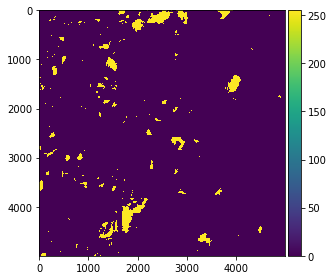

In [58]:
dilated = multi_dil(predictions_local,7)
closed = area_closing(dilated, 50000)
multi_eroded = multi_ero(closed, 7)
opened = opening(multi_eroded)

In [76]:
label_im = label(opened)
regions = regionprops(label_im)

df = pd.DataFrame(regionprops_table(label_im,properties=['centroid','area']))

df = df.sort_values(by='area',ascending=False)
df.head()

,centroid-0,centroid-1,area
264,4158.013945,1863.701468,131088
2,148.985320,2452.053885,81061
104,1493.480004,3968.564662,57112
285,4503.997244,1435.684575,39908
25,302.182217,2006.226172,39859


In [92]:
ims_17 = []
ims_22 = []
for index,row in df.iterrows():
    ims_17.append(ds_local[0,:3,int(round(row['centroid-0']))-128:int(round(row['centroid-0']))+128,int(round(row['centroid-1']))-128:int(round(row['centroid-1']))+128])
    ims_22.append(ds_local[1,:3,int(round(row['centroid-0']))-128:int(round(row['centroid-0']))+128,int(round(row['centroid-1']))-128:int(round(row['centroid-1']))+128])

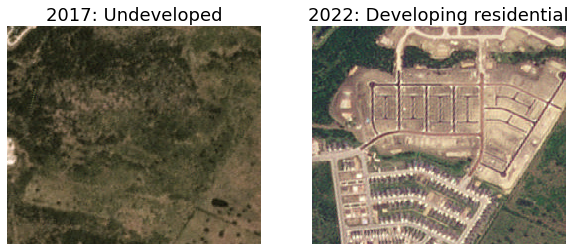

In [128]:
import matplotlib.pyplot as plt
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ims_17[2].plot.imshow(ax=ax1)
ax1.title.set_text('2017: Undeveloped')
ims_22[2].plot.imshow(ax=ax2)
ax2.title.set_text('2022: Developing residential')
ax1.axis('off')
ax2.axis('off')
plt.rcParams.update({'font.size': 14})

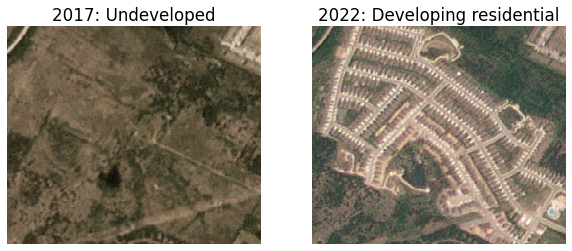

In [131]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ims_17[5].plot.imshow(ax=ax1)
ax1.title.set_text('2017: Undeveloped')
ims_22[5].plot.imshow(ax=ax2)
ax2.title.set_text('2022: Developing residential')
ax1.axis('off')
ax2.axis('off')
plt.rcParams.update({'font.size': 14})

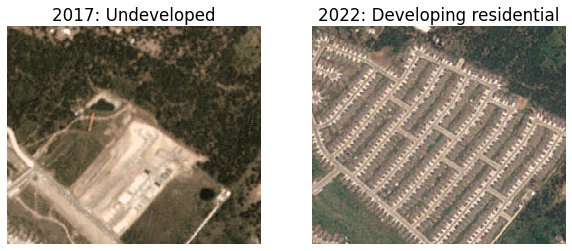

In [136]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ims_17[7].plot.imshow(ax=ax1)
ax1.title.set_text('2017: Undeveloped')
ims_22[7].plot.imshow(ax=ax2)
ax2.title.set_text('2022: Developing residential')
ax1.axis('off')
ax2.axis('off')
plt.rcParams.update({'font.size': 14})